# Peer-graded Assignment: Дополнительные признаки

### Библиотеки

In [1]:
import pickle
from IPython.display import Image
import pandas as pd
from pandas.tseries.holiday import get_calendar, USFederalHolidayCalendar
import numpy as np
import calendar
from time import mktime
from sklearn.linear_model import Lasso, LinearRegression, Ridge
import matplotlib.pyplot as plt
import os
import warnings
from xgboost import XGBRegressor as xgbr
from sklearn.preprocessing import PolynomialFeatures as PF
import itertools
import bs4
import requests
from time import sleep
%pylab inline

/home/feshch/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


# C прошлой недели я ушёл с результатом 18.21. На этой неделе добавлю данных погоды и полиномиальных признаков.

## Берем с Kaggle интересующие нас регионы

In [2]:
kaggle_regions = pd.Series(pd.read_csv('../Week4/sample_solution.csv',\
                                       index_col='id').index).apply(lambda x:x[:4]).value_counts().index

### Данные за 2016

In [4]:
data = pd.DataFrame()
for y in range(2016, 2017, 1):
    data = pd.concat([data, pd.read_csv('data_'+str(y)+'.csv', index_col='Unnamed: 0')])
data.index = pd.to_datetime(data.index)
data = data[[col for col in kaggle_regions]]
data.head()

,1434,1225,1176,1480,1335,1383,1235,1387,1130,1336,...,1273,1483,1279,2119,1285,1386,1377,1339,2069,1376
2016-01-01 00:00:00,5,14,40,18,103,260,213,93,846,109,...,49,38,47,7,490,56,51,16,4,55
2016-01-01 01:00:00,7,11,34,37,87,312,271,156,594,131,...,86,64,102,1,553,91,107,39,0,163
2016-01-01 02:00:00,1,25,56,67,37,235,214,112,377,88,...,93,63,55,1,462,61,130,39,0,183
2016-01-01 03:00:00,6,7,56,47,17,152,152,110,327,54,...,55,34,30,0,281,51,115,23,0,188
2016-01-01 04:00:00,0,2,47,50,9,95,62,56,318,22,...,29,46,24,1,144,32,57,22,0,135


### Признаки косинусов для недельной сезонности, признак тренда

In [5]:
Kw=84
p = 2.*pi/168.
for i in range(1, Kw+1):
    phi = p*i
    data['wsin'+str(i)] = sin(np.array(list(range(0, len(data))))*phi)
    data['wcos'+str(i)] = cos(np.array(list(range(0, len(data))))*phi)
data['trend'] = list(range(len(data)))

### Признаки праздников

In [6]:
cal = get_calendar('USFederalHolidayCalendar')
hld = cal.holidays(pd.datetime(2009, 1, 1), pd.datetime(2016, 6, 30))
data['hol'] = pd.Series(data.index).apply(lambda x: int(x.date() in hld)).values

### Признаки погоды: температура, ветер
#### Парсинг с https://www.wunderground.com/history/

In [47]:
data_temperature = []
data_temperature_wind = []
data_wind = []

start_time = '2015-12-31 00:00:00'
end_time = '2016-07-02 00:00:00'
p = pd.date_range(start=start_time, end=end_time, freq='D')
weather_time_index = pd.date_range(start=start_time, end=\
                                   str(pd.to_datetime(end_time)+datetime.timedelta(hours=1)), freq='H')
weather_time_index[[0, -1]]

DatetimeIndex(['2015-12-31 00:00:00', '2016-07-02 01:00:00'], dtype='datetime64[ns]', freq=None)

In [48]:
%%time
date_weather = pd.DataFrame(columns=['temperature', 'wind', 'time'], index=weather_time_index)

# будем брать последние данные за час для соблюдения принципа 
# причинности предсказаний и учитывать их в следующий час
# надеюсь, что данные есть по всем нужным дням-часам(хотя бы без больших пропусков)
# в случае отсутсвия берутся последние
previous_hour = -1

index_counter = 1
for date in p: 
    if(not date):
        break
        
     # задержки для неравномерности запросов 
    sleep(0.1*np.random.randint(1, 10))
    req = requests.get('https://www.wunderground.com/history/airport/KNYC/{}/{}/{}/'\
          'DailyHistory.html?req_city=New+York&req_state=NY&req_statename=New+York&reqdb.'\
          'zip=10001&reqdb.magic=11&reqdb.wmo=99999&MR=1'.format(date.year, date.month, date.day))
    
    parser = bs4.BeautifulSoup(req.text, 'lxml')
    p1 = parser.findAll('tr', attrs={'class': "no-metars"})
    print (date)
    for res in p1:
        # hour hh:51
        child = res.findChild('td')
        if(child):
            time = child.text
            hour = int(time[:time.find(':')])
            
            # приводим к интервалу 0-23 часа
            if(time.find('PM') != -1 and hour != 12):
                hour += 12
            if(time.find('AM') != -1 and hour == 12):
                hour = 0
                
            # перепишем данные, если есть посвежее    
            if(previous_hour == hour):
                index_counter -= 1
            previous_hour = hour
            
        
        #temperature, wind
        child = res.findChild('span', attrs={'class': 'wx-value'})
        if (child):
            temperature = child.text
            child = child.findNext('span', attrs={'class': 'wx-value'})
            if(child):
                wind = child.text
            else:
                print("error: no wind data for: ", hour, date)
                pass
        else:
            print("error: no temperature data for: ", hour, date)
            pass
        date_weather['temperature'][index_counter] = temperature
        date_weather['wind'][index_counter] = wind
        date_weather['time'][index_counter] = time
        index_counter += 1

2015-12-31 00:00:00
2016-01-01 00:00:00
2016-01-02 00:00:00
2016-01-03 00:00:00
2016-01-04 00:00:00
2016-01-05 00:00:00
2016-01-06 00:00:00
2016-01-07 00:00:00
2016-01-08 00:00:00
2016-01-09 00:00:00
2016-01-10 00:00:00
2016-01-11 00:00:00
2016-01-12 00:00:00
2016-01-13 00:00:00
2016-01-14 00:00:00
2016-01-15 00:00:00
2016-01-16 00:00:00
2016-01-17 00:00:00
2016-01-18 00:00:00
2016-01-19 00:00:00
2016-01-20 00:00:00
2016-01-21 00:00:00
2016-01-22 00:00:00
2016-01-23 00:00:00
2016-01-24 00:00:00
2016-01-25 00:00:00
2016-01-26 00:00:00
2016-01-27 00:00:00
2016-01-28 00:00:00
2016-01-29 00:00:00
2016-01-30 00:00:00
2016-01-31 00:00:00
2016-02-01 00:00:00
2016-02-02 00:00:00
2016-02-03 00:00:00
2016-02-04 00:00:00
2016-02-05 00:00:00
2016-02-06 00:00:00
2016-02-07 00:00:00
2016-02-08 00:00:00
2016-02-09 00:00:00
2016-02-10 00:00:00
2016-02-11 00:00:00
2016-02-12 00:00:00
2016-02-13 00:00:00
2016-02-14 00:00:00
2016-02-15 00:00:00
2016-02-16 00:00:00
2016-02-17 00:00:00
2016-02-18 00:00:00


In [115]:
date_weather = date_weather[date_weather.wind == date_weather.wind]
#date_weather = date_weather.iloc[:, :2]
#date_weather.to_csv('weather.csv')

In [7]:
date_weather = pd.read_csv('weather.csv', index_col='Unnamed: 0')
date_weather.index = pd.to_datetime(date_weather.index)
#date_weather.head()

### Так выглядят признаки

In [8]:
for col in date_weather.columns:
    data[col] = date_weather[col][data.index]
data.iloc[-5:, 102:]

,wsin1,wcos1,wsin2,wcos2,wsin3,wcos3,wsin4,wcos4,wsin5,wcos5,...,wsin82,wcos82,wsin83,wcos83,wsin84,wcos84,trend,hol,temperature,wind
2016-06-30 19:00:00,-0.185912,0.982566,-0.365341,0.930874,-0.532032,0.846724,-0.680173,0.733052,-0.804598,0.593820,...,-0.365341,-0.930874,-0.185912,-0.982566,-3.716286e-13,-1.0,4363,0,18.3,13.3
2016-06-30 20:00:00,-0.149042,0.988831,-0.294755,0.955573,-0.433884,0.900969,-0.563320,0.826239,-0.680173,0.733052,...,0.294755,0.955573,0.149042,0.988831,-1.117081e-12,1.0,4364,0,18.9,13.9
2016-06-30 21:00:00,-0.111964,0.993712,-0.222521,0.974928,-0.330279,0.943883,-0.433884,0.900969,-0.532032,0.846724,...,-0.222521,-0.974928,-0.111964,-0.993712,7.868010e-13,-1.0,4365,0,20.0,12.2
2016-06-30 22:00:00,-0.074730,0.997204,-0.149042,0.988831,-0.222521,0.974928,-0.294755,0.955573,-0.365341,0.930874,...,0.149042,0.988831,0.074730,0.997204,-4.565211e-13,1.0,4366,0,20.6,11.1
2016-06-30 23:00:00,-0.037391,0.999301,-0.074730,0.997204,-0.111964,0.993712,-0.149042,0.988831,-0.185912,0.982566,...,-0.074730,-0.997204,-0.037391,-0.999301,1.262412e-13,-1.0,4367,0,21.7,10.6


## При предсказании линейной регрессией (в том числе и с регуляризаторами) часто предсказываемые значения отрицательные. У модели нет информации о том, что когда несколько понижающих количество поездок факторов накладываются друг на друга, оно не может упасть ниже нуля. Возможно, это плохая погода, выходные, праздники, ночное время суток. Для учёта этого обстоятельства добавлю полиномиальные признаки от некоторых из этих признаков. Сначала делаю регрессию без них, и гляну на коэффициенты, чтобы понять, что это могут быть за признаки.

## Валидация на мае, тюнинг регуляризации:

      0          1
0  0.01  20.158000
1  0.05  20.020631
2  0.10  19.925910
3  0.15  19.877375
4  0.20  19.855841
5  0.30  19.866783
6  0.40  19.923979
7  0.50  20.009450
8  1.00  20.663477


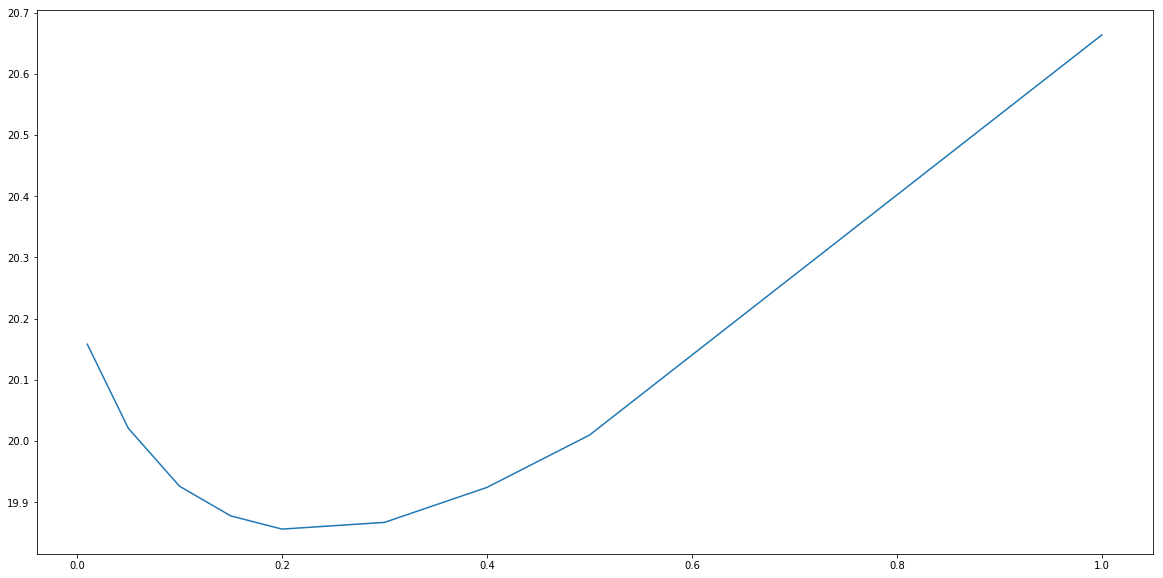

In [29]:
train_size = 6*168 # Эмпирически выверенный оптимум длины обучающей выборки для наилучшего прогноза
histends = data.index[(pd.to_datetime('2016-04-30 23:00:00')<=data.index) &\
                      (data.index<=pd.to_datetime('2016-05-31 17:00:00'))]
forbegs = data.index[(pd.to_datetime('2016-05-01 00:00:00')<=data.index) &\
                     (data.index<=pd.to_datetime('2016-05-31 18:00:00'))]
forends = data.index[(pd.to_datetime('2016-05-01 05:00:00')<=data.index) &\
                     (data.index<=pd.to_datetime('2016-05-31 23:00:00'))]
#graph = []
for alpha in [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 1]:
    lr = Lasso(alpha=alpha, warm_start=True, max_iter=1000000)
    errors = []
    for t, he in enumerate(histends):
        #if not t%24:
         #   print(he)
        # Обучающая выборка
        train_X = data[data.index<=he].iloc[-train_size:, 102:]
        train_y = data[data.index<=he].iloc[-train_size:, :102]
        test_X = data.iloc[:, 102:][(forbegs[t]<=data.index) & (data.index<=forends[t])]
        test_y = data.iloc[:, :102][(forbegs[t]<=data.index) & (data.index<=forends[t])]
        lr.fit(X=train_X, y=train_y)
        lr_pred = lr.predict(test_X)
        lr_pred = lr_pred*(lr_pred>0) # Убираю сразу отрицательные поездки, чтоб проследить, что полиномиальные признаки ошибку уменьшат
        pd.DataFrame(data=lr_pred, columns=test_y.columns, index=test_y.index)
        # Ошибки, по которым потом рассичтаем Q_may, являющийся просто mean absolute error
        errors.append(test_y-lr_pred)
    print(alpha, 'Q_may: ', mean([mean(mean(abs(error))) for error in errors]))
    graph.append([alpha, mean([mean(mean(abs(error))) for error in errors])])
graph = sorted(graph)
print(pd.DataFrame(graph))
plt.figure(figsize = (20, 10))
plt.plot(array(graph)[:, 0], array(graph)[:, 1])

### Коэффициенты регрессии:

In [30]:
for m, col in sorted([(mean(lr.coef_[:,i]), col) for i, col in enumerate(data.columns[102:])]):
    print(col, m)

wsin84 -841979652847.0193
wsin7 -54.73024046641891
wsin14 -39.78647938456483
hol -32.20786543051899
wcos7 -21.88335872178113
wsin13 -15.171909056657034
wsin6 -11.50131259245031
wcos15 -9.247008329370443
wsin35 -8.906783801840808
wcos12 -7.384081360026236
wcos22 -5.630356562272352
wcos5 -5.3927280728458955
wsin16 -5.1594797419092595
wcos16 -4.817120194200025
wsin42 -4.2669444289502225
wsin19 -4.140543334232978
wsin12 -4.041229710528944
wcos42 -3.5973094431373074
wsin34 -3.3249944318168376
wcos9 -3.3184440163908016
wsin3 -3.200909148275015
wsin21 -3.0976562549199644
wcos35 -3.0419229352793526
wcos27 -2.3552443596932635
wsin10 -1.8122668876575068
wcos10 -1.728814784110224
wsin23 -1.6621470654981139
wsin77 -1.6347842867021425
wsin22 -1.576464021432292
wcos48 -1.3500263940590802
wsin70 -1.187135479031438
wcos30 -1.1506693191417607
wcos33 -1.0682206335716826
wsin1 -1.0594431007585627
wsin17 -1.0051610352849003
wsin57 -0.8390348001126106
wsin41 -0.8148506038259489
wsin54 -0.8063014996718436
w

## Как и предполагалось, сильно снижено количество поездок в ветренную погоду, праздники. Скорее всего, и в выходные, но по непрерывным признакам не скажу наверняка, буду работать для получения полиномиальных с категориальными.

In [90]:
pol_columns = ['hol','wind', 'temperature']
pol_data = pd.DataFrame(pd.get_dummies(data.index.weekday, drop_first=True).iloc[:, -2:])
pol_data.index=data.index
pol_data.columns = ['Saturday', 'Sunday']
for col in pol_columns:
    pol_data[col] = data[col]
pol_data.head()

,Saturday,Sunday,hol,wind,temperature
2016-01-01 00:00:00,0,0,1,4.0,5.6
2016-01-01 01:00:00,0,0,1,4.0,5.6
2016-01-01 02:00:00,0,0,1,3.9,5.0
2016-01-01 03:00:00,0,0,1,3.3,5.0
2016-01-01 04:00:00,0,0,1,1.8,5.0


### Признаки для учёта пассажиров с разным рабочим графиком

In [91]:
poly = PF(2)
new_features = pd.DataFrame(poly.fit_transform(pol_data.iloc[:, :3]), columns=poly.get_feature_names(input_features=pol_data.columns[:3]))
new_features.index = pol_data.index
new_features = new_features.iloc[:, 5:9].drop('Sunday^2', 1)
pol_data = pd.concat([new_features, pol_data], 1)
pol_data.head()

,Saturday Sunday,Saturday hol,Sunday hol,Saturday,Sunday,hol,wind,temperature
2016-01-01 00:00:00,0.0,0.0,0.0,0,0,1,4.0,5.6
2016-01-01 01:00:00,0.0,0.0,0.0,0,0,1,4.0,5.6
2016-01-01 02:00:00,0.0,0.0,0.0,0,0,1,3.9,5.0
2016-01-01 03:00:00,0.0,0.0,0.0,0,0,1,3.3,5.0
2016-01-01 04:00:00,0.0,0.0,0.0,0,0,1,1.8,5.0


### Признаки для учёта погодных условий

In [92]:
new_features = pd.DataFrame(poly.fit_transform(pol_data.iloc[:, -2:]), columns=poly.get_feature_names(input_features=pol_data.columns[-2:]))
new_features.index = pol_data.index
new_features = new_features.iloc[:, -2:-1]
pol_data = pd.concat([pol_data, new_features], 1)
pol_data.head()

,Saturday Sunday,Saturday hol,Sunday hol,Saturday,Sunday,hol,wind,temperature,wind temperature
2016-01-01 00:00:00,0.0,0.0,0.0,0,0,1,4.0,5.6,22.4
2016-01-01 01:00:00,0.0,0.0,0.0,0,0,1,4.0,5.6,22.4
2016-01-01 02:00:00,0.0,0.0,0.0,0,0,1,3.9,5.0,19.5
2016-01-01 03:00:00,0.0,0.0,0.0,0,0,1,3.3,5.0,16.5
2016-01-01 04:00:00,0.0,0.0,0.0,0,0,1,1.8,5.0,9.0


### Рабочий график и погодные условия

In [100]:
feature_set_2 = pol_data.columns[-3:] # Рабочий график
feature_set_1 = pol_data.columns[:-3] # Погода
new_features = pd.DataFrame(poly.fit_transform(pol_data), columns=poly.get_feature_names(pol_data.columns))
new_features.index = pol_data.index
for i in feature_set_1:
    for j in feature_set_2:
        pol_data[i+' '+j] = new_features[i+' '+j]
pol_data.head()

,Saturday Sunday,Saturday hol,Sunday hol,Saturday,Sunday,hol,wind,temperature,wind temperature,Saturday Sunday wind,...,Sunday hol wind temperature,Saturday wind,Saturday temperature,Saturday wind temperature,Sunday wind,Sunday temperature,Sunday wind temperature,hol wind,hol temperature,hol wind temperature
2016-01-01 00:00:00,0.0,0.0,0.0,0,0,1,4.0,5.6,22.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.6,22.4
2016-01-01 01:00:00,0.0,0.0,0.0,0,0,1,4.0,5.6,22.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.6,22.4
2016-01-01 02:00:00,0.0,0.0,0.0,0,0,1,3.9,5.0,19.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.9,5.0,19.5
2016-01-01 03:00:00,0.0,0.0,0.0,0,0,1,3.3,5.0,16.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.3,5.0,16.5
2016-01-01 04:00:00,0.0,0.0,0.0,0,0,1,1.8,5.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.8,5.0,9.0


In [103]:
data = pd.concat([data, pol_data], 1)

      0          1
0  0.01  20.909935
1  0.05  20.574345
2  0.15  20.371184
3  0.20  20.359358
4  0.30  20.392188
5  0.40  20.466943
6  0.70  20.808838
7  1.00  21.219714


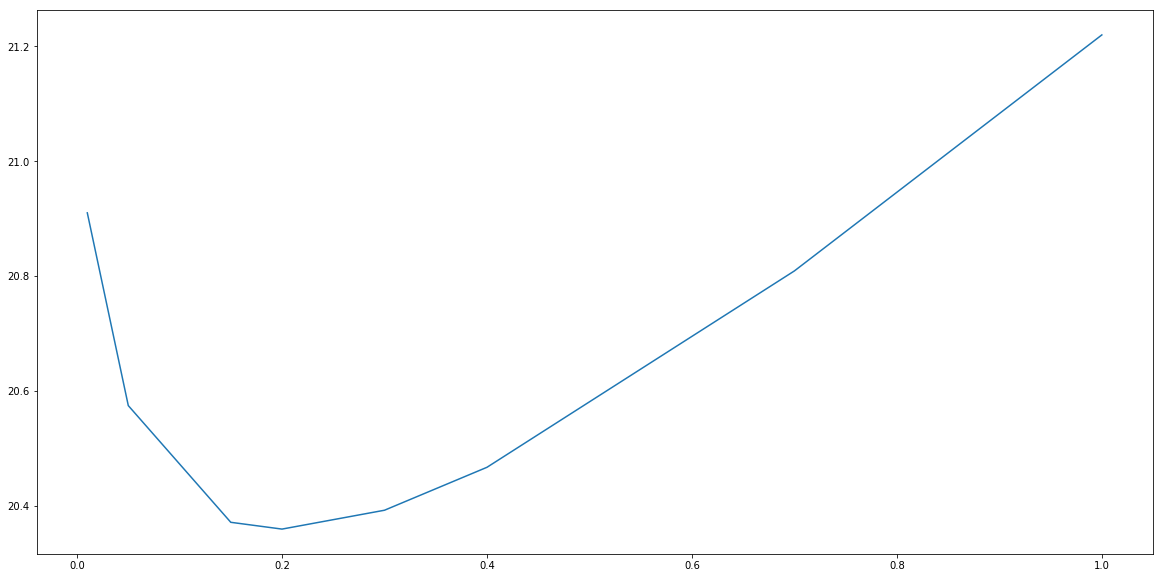

In [110]:
train_size = 7*168 # Эмпирически выверенный оптимум длины обучающей выборки для наилучшего прогноза
histends = data.index[(pd.to_datetime('2016-04-30 23:00:00')<=data.index) &\
                      (data.index<=pd.to_datetime('2016-05-31 17:00:00'))]
forbegs = data.index[(pd.to_datetime('2016-05-01 00:00:00')<=data.index) &\
                     (data.index<=pd.to_datetime('2016-05-31 18:00:00'))]
forends = data.index[(pd.to_datetime('2016-05-01 05:00:00')<=data.index) &\
                     (data.index<=pd.to_datetime('2016-05-31 23:00:00'))]
graph = []
for alpha in [1., 0.7, 0.4, 0.3, 0.2, 0.15, 0.05, 0.01]:
    lr = Lasso(alpha=alpha, warm_start=True, max_iter=1000000)
    errors = []
    for t, he in enumerate(histends):
        #if not t%24:
         #   print(he)
        # Обучающая выборка
        train_X = data[data.index<=he].iloc[-train_size:, 102:]
        train_y = data[data.index<=he].iloc[-train_size:, :102]
        test_X = data.iloc[:, 102:][(forbegs[t]<=data.index) & (data.index<=forends[t])]
        test_y = data.iloc[:, :102][(forbegs[t]<=data.index) & (data.index<=forends[t])]
        lr.fit(X=train_X, y=train_y)
        lr_pred = lr.predict(test_X)
        lr_pred = lr_pred*(lr_pred>0) # Убираю сразу отрицательные поездки, чтоб проследить, что полиномиальные признаки ошибку уменьшат
        pd.DataFrame(data=lr_pred, columns=test_y.columns, index=test_y.index)
        # Ошибки, по которым потом рассичтаем Q_may, являющийся просто mean absolute error
        errors.append(test_y-lr_pred)
    #print(alpha, 'Q_may: ', mean([mean(mean(abs(error))) for error in errors]))
    graph.append([alpha, mean([mean(mean(abs(error))) for error in errors])])
graph = sorted(graph)
print(pd.DataFrame(graph))
plt.figure(figsize = (20, 10))
plt.plot(array(graph)[:, 0], array(graph)[:, 1])
graph = np.array(graph)
alpha = graph[:, 0][graph[:, 1]==min(graph[:, 1])][0]

In [127]:
%%time

first_history_end = pd.to_datetime('2016-05-31 23:00:00')
last_history_end = pd.to_datetime('2016-06-30 17:00:00')
first_forecast_beg = pd.to_datetime('2016-06-01 00:00:00')
last_forecast_beg = pd.to_datetime('2016-06-30 18:00:00')
first_forecast_end = pd.to_datetime('2016-06-01 05:00:00')
last_forecast_end = pd.to_datetime('2016-06-30 23:00:00')
test_size = 6

train_size = 7*168 # Эмпирически выверенный оптимум длины обучающей выборки для наилучшего прогноза

histends = data.index[(first_history_end<=data.index) & (data.index<=last_history_end)]
forbegs = data.index[(first_forecast_beg<=data.index) & (data.index<=last_forecast_beg)]
forends = data.index[(first_forecast_end<=data.index) & (data.index<=last_forecast_end)]

lr = Lasso(alpha=alpha, warm_start=True, max_iter=1000000)
errors = []
PREDICTION = pd.DataFrame()
for t, he in enumerate(histends):
    # Обучающая выборка
    train_X = data[data.index<=he].iloc[-train_size:, 102:]
    # Будем работать с количеством поездок для разных регионов как с вектором
    # чтобы получилась своя модель для каждого региона
    train_y = data[data.index<=he].iloc[-train_size:, :102]
    # Тестовая выборка
    test_X = data.iloc[:, 102:][(forbegs[t]<=data.index) & (data.index<=forends[t])]
    test_y = data.iloc[:, :102][(forbegs[t]<=data.index) & (data.index<=forends[t])]
    # Лассо регрессия
    lr.fit(X=train_X, y=train_y)
    lr_pred = lr.predict(test_X)
    lr_pred = lr_pred*(lr_pred>0) # Убираю сразу отрицательные поездки, чтоб проследить, что полиномиальные признаки ошибку уменьшат
    lr_pred = pd.DataFrame(data=lr_pred, columns=test_y.columns, index=test_y.index)
    # Ошибки, по которым потом рассичтаем Q_june, являющийся просто mean absolute error
    errors.append(test_y-lr_pred)
    pred_tmp = pd.DataFrame()
    for r in kaggle_regions:
        pred_tmp = pd.concat([pred_tmp, pd.DataFrame(index=r+\
                                pd.Series([str(he)]*6, name='id').apply(lambda x: '_'+x[:10]+'_'+str(int(x[11:13]))+'_')+\
                                [str(i) for i in range(1, 1+test_size, 1)],\
                                data=lr_pred[r].values, columns=['y'])])
    PREDICTION = pd.concat([PREDICTION, pred_tmp])
print('Q_june: '+str(mean([mean(mean(abs(error))) for error in errors])))
PREDICTION.to_csv('my_submission_lasso.csv')

Q_june: 17.522912196247447
CPU times: user 27min 49s, sys: 2min 54s, total: 30min 43s
Wall time: 26min 49s


## Прогноз получился точнее, чем на прошлой неделе (Q_june = 18.21)

# Сабмишшен https://www.kaggle.com/submissions/7460936

## Модель можно улучшать, например, новыми признаками, ещё она сейчас никак не вознаграждается за схожесть моделей в географически близких регионах, не работает с годовой сезонностью.